<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=140828035" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
from spx_strategies import *
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/spx-option-spread-backtester/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)



#########################
# Settings for backtest #
#########################
purchase_time = '16:00:00'
# In dollars
commission = 1.5



files = [
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
#    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
 #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1545_1600.csv"
  #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2018_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2017_1545_1600.csv"
  # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2016_1545_1600.csv"
  # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1dte_all.csv",
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1dte_all.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1dte_all.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1dte_all.csv"
]
li = []
for f in files:   
    df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
df['delta'] = df['delta'].abs()

if 'dte' not in df:
    raise Exception("dte must be present")

initial_portfolio_value = df.loc[1,'price']*20

df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty['Date'] = pd.to_datetime(df_ty['Date'])

Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-13-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-14-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-01-15.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-17-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-12-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-08-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-18-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-22-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-02-23.db
Copying db file to ou

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
    for f in filenames:
        if 'spx' in f:
            df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
            df.rename(columns={'underlying':'price'},inplace=True)
            df.drop(columns=['Unnamed: 0'], inplace=True)
            df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
            df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
            df['delta'] = df['delta'].abs()
            initial_portfolio_value = df.loc[1,'price']*20
        elif 'irx' in f:
            df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
            df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
            df_irx['Adj Close']*= 100
            df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
            df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
            df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
            df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)



In [3]:
df[(df['expiration']=='2023-08-18')&(df['quote_time']=='09:31:00')&(df['strike']==4400)]

,bid,ask,strike,expiration,price,iv,delta,type,quote_time,quote_date,dte
7573378,27.10,28.10,4400.0,2023-08-18,4404.33,0.241884,0.535437,C,09:31:00,2023-08-17,1
7573379,6.20,6.60,4400.0,2023-08-18,4404.33,0.083896,0.405804,P,09:31:00,2023-08-17,1
7573380,31.00,31.40,4400.0,2023-08-18,4404.33,0.276170,0.531801,C,09:31:00,2023-08-17,1
7573381,10.00,10.20,4400.0,2023-08-18,4404.33,0.120522,0.433390,P,09:31:00,2023-08-17,1
8303498,0.00,6.50,4400.0,2023-08-18,4370.36,0.293341,0.200905,C,09:31:00,2023-08-18,0
8303499,20.60,49.40,4400.0,2023-08-18,4370.36,0.253820,0.834001,P,09:31:00,2023-08-18,0
8303500,0.45,0.55,4400.0,2023-08-18,4370.36,0.160348,0.061917,C,09:31:00,2023-08-18,0
8303501,57.40,58.10,4400.0,2023-08-18,4370.36,0.867753,0.607560,P,09:31:00,2023-08-18,0


# Backtest Optimization

In [4]:
# purchase_time = '16:01:00'
# dos = DeltaOptionSelector(short_puts=0.04, short_calls=0.02)
# # dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# #ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# ex_pol = MaxLossDynamicExitPolicy(1.5)
# strat = StaticEntryDynamicExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [5]:
def run_backtest(strat, df):
    return strat.evaluate(df)['Cumulative Return On Scaled Max Risk']

In [6]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float("delta_sp", 0.002, 0.45)
    delta_lp_trial = trial.suggest_float("delta_lp", 0.002, 0.45)
    delta_sc_trial = trial.suggest_float("delta_sc", 0.002, 0.45)
    delta_lc_trial = trial.suggest_float("delta_lc", 0.002, 0.45)
    
    if (delta_lp_trial >= delta_sp_trial) or (delta_lc_trial <= delta_sc_trial):
        return -1
#     max_loss = trial.suggest_float("max_loss", 1.25, 4.0)
   
    dos = DeltaOptionSelector(short_puts=delta_sp_trial, long_puts=delta_lp_trial,short_calls=delta_sc_trial, long_calls=delta_lc_trial)
    ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
    ex_pol = HoldToExpStaticExitPolicy('16:00:00')

    strategy = StaticEntryStaticExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [7]:
study_name = f"optimal-short-ic-study_2023-2023_1DTE_{datetime.today().strftime('%Y-%m-%d-%H')}"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, purchase_time), n_trials = 10)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-08-23 22:00:57,088] A new study created in RDB with name: optimal-short-ic-study_2023-2023_1DTE_2023-08-23-22
[I 2023-08-23 22:00:57,262] Trial 0 finished with value: -1.0 and parameters: {'delta_sp': 0.1732396124732342, 'delta_lp': 0.29159981659706774, 'delta_sc': 0.053204691724450304, 'delta_lc': 0.3447902951322901}. Best is trial 0 with value: -1.0.
[I 2023-08-23 22:00:57,386] Trial 1 finished with value: -1.0 and parameters: {'delta_sp': 0.1531291460980381, 'delta_lp': 0.24423197824228565, 'delta_sc': 0.2937260061618209, 'delta_lc': 0.007659851149257001}. Best is trial 0 with value: -1.0.
[I 2023-08-23 22:00:57,514] Trial 2 finished with value: -1.0 and parameters: {'delta_sp': 0.20964549157794726, 'delta_lp': 0.04415861397731715, 'delta_sc': 0.14876310048779426, 'delta_lc': 0.13335731191102007}. Best is trial 0 with value: -1.0.
[I 2023-08-23 22:00:57,638] Trial 3 finished with value: -1.0 and parameters: {'delta_sp': 0.1863863588973724, 'delta_lp': 0.18696638424639597, 'd

Best Score:  0.988
Best Params: 
  delta_lc: 0.12224265576070399
  delta_lp: 0.07677053803964116
  delta_sc: 0.03166351197602333
  delta_sp: 0.29668197589774736


# Backtest with current best score

*****  BACKTEST RESULTS  ****

Cumulative return:                     -1.261 % 
Max Drawdown:                           -4.15 % 
Trading Days:                              28 
Wins:                                      22 
Losses:                                     6 
Breakeven:                                  0 
Win/Loss Ratio:                        78.571 % 
Mean Win:                             381.818 $ 
Mean Win Trans Return:                  0.436 % 
Mean Loss:                            -1589.5 $ 
Mean Loss Trans Return:                -1.758 % 
Mean Net Trans:                       -40.607 $ 
Mean Trans Return:                     -0.051 % 
Std Dev of Net Trans:                 990.062 
Std Dev of Trans Return:                0.011 
Max Loss:                             -3231.0 $ 
Max Win:                               1689.5 $ 
Sharpe Ratio static STD:               -1.023 
Sharpe Ratio with RF STD:              -1.023 
Risk Adj Cumulative Return:          -112.737 
Dampene

,trade_date,expiration,trade_count,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,gross_max_loss,net_max_loss,return_on_max_risk,scaled_return_on_max_risk
0,2023-07-14,2023-07-17,4.0,0.296682,4490.0,0.286450,467.5,0.031664,4555.0,0.027620,25.0,0.122243,4535.0,0.114801,-140.0,0.076771,4460.0,0.070176,-95.0,257.5,0.0,0.0,4526.69,6.0,0.0,251.5,90452.3,251.5,NaN,0.002788,0.000207,3000.0,2742.5,0.091705,1.001834
1,2023-07-17,2023-07-18,4.0,0.296682,4510.0,0.269545,467.5,0.031664,4570.0,0.031123,25.0,0.122243,4555.0,0.102093,-105.0,0.076771,4485.0,0.076332,-105.0,282.5,-332.0,0.0,4558.32,6.0,-332.0,608.5,91060.8,860.0,0.006727,0.009534,0.000208,2500.0,2217.5,0.274408,1.005488
2,2023-07-18,2023-07-19,4.0,0.296682,4540.0,0.246720,407.5,0.031664,4610.0,0.027334,25.0,0.122243,4590.0,0.100680,-117.5,0.076771,4515.0,0.074479,-105.0,210.0,0.0,0.0,4568.48,6.0,0.0,204.0,91264.8,1064.0,0.002240,0.011796,0.000208,2500.0,2290.0,0.089083,1.001782
3,2023-07-19,2023-07-20,4.0,0.296682,4550.0,0.259541,467.5,0.031664,4630.0,0.030187,35.0,0.122243,4605.0,0.111529,-160.0,0.076771,4520.0,0.072510,-110.0,232.5,0.0,1599.0,4534.01,6.0,1599.0,-1372.5,89892.3,-308.5,-0.015039,-0.003420,0.000208,3000.0,2767.5,-0.495935,0.990081
4,2023-07-20,2023-07-21,4.0,0.296682,4520.0,0.288242,477.5,0.031664,4585.0,0.031538,30.0,0.122243,4560.0,0.120306,-125.0,0.076771,4500.0,0.075295,-85.0,297.5,0.0,0.0,4537.79,6.0,0.0,291.5,90183.8,-17.0,0.003243,-0.000188,0.000208,2000.0,1702.5,0.171219,1.003424
5,2023-07-21,2023-07-24,4.0,0.296682,4520.0,0.244659,417.5,0.031664,4590.0,0.024226,20.0,0.122243,4570.0,0.108001,-125.0,0.076771,4495.0,0.072015,-100.0,212.5,0.0,0.0,4552.82,6.0,0.0,206.5,90390.3,189.5,0.002290,0.002101,0.000208,2500.0,2287.5,0.090273,1.001805
6,2023-07-24,2023-07-25,4.0,0.296682,4540.0,0.279923,405.0,0.031664,4605.0,0.022217,20.0,0.122243,4585.0,0.107855,-130.0,0.076771,4510.0,0.062230,-80.0,215.0,0.0,0.0,4571.38,6.0,0.0,209.0,90599.3,398.5,0.002312,0.004418,0.000208,3000.0,2785.0,0.075045,1.001501
7,2023-07-25,2023-07-26,4.0,0.296682,4545.0,0.285413,862.5,0.031664,4650.0,0.030238,45.0,0.122243,4625.0,0.100910,-195.0,0.076771,4500.0,0.065590,-140.0,572.5,0.0,0.0,4566.59,6.0,0.0,566.5,91165.8,965.0,0.006253,0.010698,0.000209,4500.0,3927.5,0.144239,1.002885
8,2023-07-26,2023-07-27,4.0,0.296682,4550.0,0.258299,417.5,0.031664,4620.0,0.030491,30.0,0.122243,4605.0,0.094519,-125.0,0.076771,4520.0,0.071739,-105.0,217.5,0.0,1623.0,4533.77,6.0,1623.0,-1411.5,89754.3,-446.5,-0.015483,-0.004950,0.000209,3000.0,2782.5,-0.507278,0.989854
9,2023-07-27,2023-07-28,4.0,0.296682,4510.0,0.263828,627.5,0.031664,4615.0,0.027242,40.0,0.122243,4585.0,0.103734,-195.0,0.076771,4460.0,0.071504,-165.0,307.5,0.0,0.0,4578.72,6.0,0.0,301.5,90055.8,-145.0,0.003359,-0.001608,0.000209,5000.0,4692.5,0.064251,1.001285


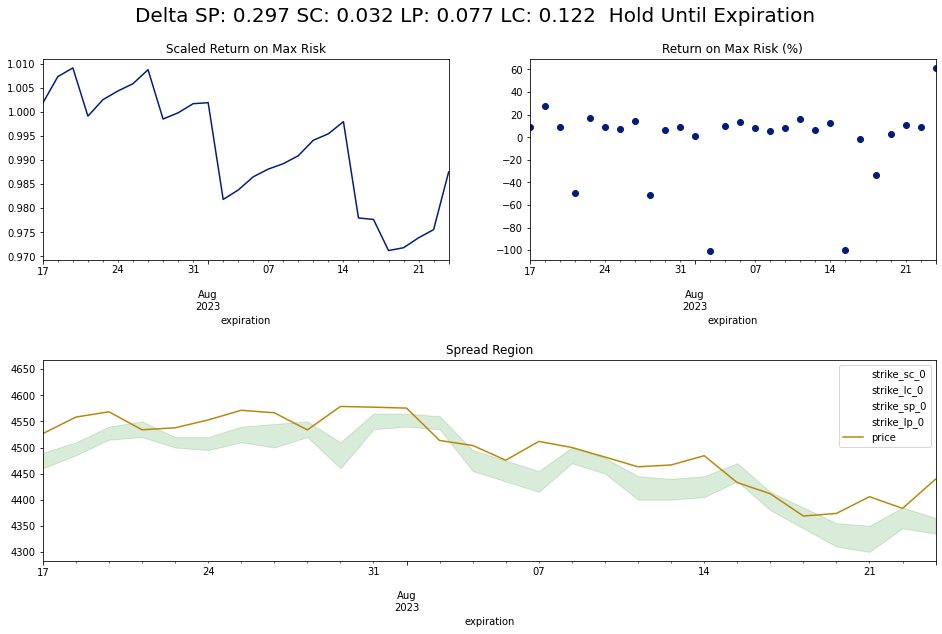

In [8]:
dos = DeltaOptionSelector(short_puts=trial.params['delta_sp'],short_calls=trial.params['delta_sc'], long_puts=trial.params['delta_lp'],long_calls=trial.params['delta_lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
ex_pol = HoldToExpStaticExitPolicy('16:00:00')
strat = StaticEntryStaticExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

# Strikes for tomorrow with current best

In [9]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [10]:
dos = DeltaOptionSelector(short_puts=trial.params['delta_sp'],short_calls=trial.params['delta_sc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2023-08-23,2023-08-24,0.296682,4415.0,0.274899,725.0,0.031664,4510.0,0.030203,40.0,2,765.0


# Strikes following the 4/2 Strategy

In [11]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2023-08-23,2023-08-24,0.04,4355.0,0.038993,75.0,0.02,4520.0,0.018828,25.0,2,100.0
